# A1 - Proposta de Modelo de Síntese de Dado Tabular em Saúde

#### Aluno: Tiago Amorim (100.675)

Esta atividade pode ser realizada individualmente ou em duplas (em caso de entrega em dupla, pede-se que apenas um dos membros da dupla realize a entrega e indique isso explicitamente no campo de comentários da entrega).
Atente-se ao horário de entrega da atividade!

O objetivo é que você proponha e gere um banco de dados sintéticos de resultados de exames de hemograma.
Não precisa ser uma abordagem baseada em deep learning, pode ser uma abordagem baseada em regras ou em modelos estatísticos clássicos.

Seguem anexadas três planilhas extraídas de uma base de resultados de exames de laboratório de análises clínicas.
São dados reais obtidos de um hemocentro do estado de São Paulo (e podem exigir etapas de limpeza de dados).
Campos de identificação foram transformados para fins de anonimização completa dos pacientes.

Proponha um método, **implemente e apresente uma base de dados sintética com, no mínimo, 1000 resultados de exames fictícios**.

Simplificação admitida: sintetizar apenas um dos parâmetros do hemograma.
Outras simplificações devem ser devidamente justificadas.
Deverá ser entregue um notebook Google Colab, explicitando e explicando sua implementação.

Responda à seguinte pergunta: **como você garante que a sua síntese de dados é realista?**
Explicite os critérios utilizados.

Sugere-se que o material suplementar anexo seja estudado, mas adianta-se que o mesmo não contêm a solução do problema.
Servem apenas como uma introdução a aspectos relevantes a serem considerados na síntese de sinais e um exemplo de abordagem na saúde.

# Ingestão Dados

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [22]:
df1 = pd.read_csv('./data1.csv', header=None)
df2 = pd.read_csv('./data2.csv', header=None)
df3 = pd.read_csv('./data3.csv', header=None)

df = pd.concat([df1, df2, df3], ignore_index=True)
df.columns = ['Date', 'Age', 'ID', 'Sex', 'Test', 'Result']
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

print(f"Data points: {len(df):,}")
print(f"Data points per column: \n{df.count()}")

Data points: 356,851
Data points per column: 
Date      356851
Age       356851
ID        356851
Sex       356851
Test      356851
Result    329043
dtype: int64


Retirando as linhas que não tem valores associados.

In [23]:
df_clean = df.dropna()
df_clean = df_clean[df_clean['Result'].str.strip() != '']
print(f"Data points after clean-up: {len(df_clean):,}")

df_clean['Result'] = df_clean['Result'].str.replace(',', '.').astype(float)
df_clean['Sex'] = df_clean['Sex'].map({'M': 0, 'F': 1})

print(f"Unique IDs: {len(df_clean['ID'].unique()):,}")

Data points after clean-up: 327,226
Unique IDs: 30,911


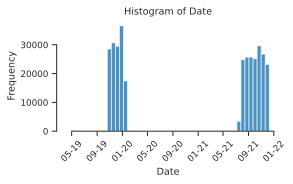

In [24]:
plt.figure(figsize=(4, 2))
df_clean['Date'].hist(bins=50, alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Histogram of Date')
plt.grid(False)

ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)

sns.despine(trim=True)

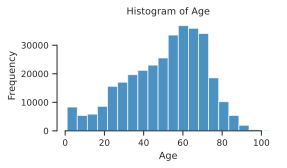

In [25]:
plt.figure(figsize=(4, 2))
df_clean['Age'].hist(bins=20, alpha=0.8)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.grid(False)
sns.despine(trim=True)

Retirando os testes que tem poucas amostras.

In [26]:
df_clean["Test"].value_counts()

Test
PLAQUETAS SANGUE               64061
NEUTRÓFILOS ABSOLUTO           63294
LINFÓCITOS ABSOLUTO            63293
LINFÓCITOS %                   63187
NEUTRÓFILOS %                  59869
MCHC                            3317
EOSINÓFILOS ABSOLUTO            3317
NEUTRÓFILOS SEGMENTADOS %       3316
LEUCÓCITOS TOTAIS               1188
LUC ABSOLUTO                    1188
LUC %                           1187
LINFOCITOS ATIPICOS TOTAL %        3
PLASMÓCITOS ABSOLUTO               3
PLASMÓCITOS%                       3
Name: count, dtype: int64

In [27]:
test_counts = df_clean['Test'].value_counts()
test_keep = test_counts[test_counts > 10].index
df_clean = df_clean[df_clean['Test'].isin(test_keep)]

print(f"Data points after clean-up: {len(df_clean):,}")

Data points after clean-up: 327,217


Avaliando os resultados por teste, alguns valores são significativamente maiores que a maior parte dos dados. Utilizando como critério de corte as amostras com valores afastados mais de $3\sigma$ da média, seriam retiradas cerca de 1 a 2% das amostras. Os histogramas em escala log mostram, em geral, uma tendência contínua até os valores muito altos. Por falta de conhecimento da área, foi assumido que estas amostras são válidas (possivelmente associadas a algumas condição médica específica).

In [28]:
outlier_std = 3

tests = {"Test": [], "Mean": [], "Median": [], "Std dev": [], "Min": [], "Max": [], "Outliers%": []}
for t in df_clean["Test"].unique():
    d = df_clean[df_clean["Test"] == t]["Result"]
    tests["Test"].append(t)
    tests["Mean"].append(d.mean())
    tests["Median"].append(d.median())
    tests["Std dev"].append(d.std())
    tests["Min"].append(d.min())
    tests["Max"].append(d.max())
    tests["Outliers%"].append(d[(d - d.mean()).abs() > outlier_std * d.std()].count() / d.count() * 100)
df_tests = pd.DataFrame(tests)
df_tests

,Test,Mean,Median,Std dev,Min,Max,Outliers%
0,PLAQUETAS SANGUE,243.820990,233.0000,120.880569,1.0,2708.0000,1.284713
1,NEUTRÓFILOS ABSOLUTO,5.383862,4.3887,4.389262,0.0,187.6820,1.376118
2,LINFÓCITOS ABSOLUTO,1.973220,1.6900,5.423368,0.0,369.2448,0.126396
3,NEUTRÓFILOS %,63.080576,63.2000,14.300539,0.0,100.0000,0.659774
4,LINFÓCITOS %,25.407839,24.7000,13.848070,0.0,100.0000,1.036606
5,MCHC,33.481519,33.6000,1.777540,25.4,45.3000,1.055170
6,EOSINÓFILOS ABSOLUTO,0.160746,0.0108,1.005763,0.0,30.9000,0.723545
7,NEUTRÓFILOS SEGMENTADOS %,56.658745,62.2500,27.833813,0.0,100.0000,0.000000
8,LEUCÓCITOS TOTAIS,7.228350,3.6150,17.730339,0.0,257.4000,1.178451
9,LUC ABSOLUTO,0.527374,0.0600,4.794664,0.0,95.5200,0.589226


In [29]:
n = len(df_clean["Test"].unique())
for i,t in enumerate(df_clean["Test"].unique()):
    fig, ax = plt.subplots(1, 3, figsize=(9, 2))
    d = df_clean[df_clean["Test"] == t]["Result"]

    d.hist(bins=10, alpha=0.8, ax=ax[0])
    ax[0].set_xlabel('Result')
    ax[0].set_ylabel('Frequency')
    ax[0].set_title(t)
    ax[0].grid(False)

    sns.boxplot(y=d, ax=ax[1])
    ax[1].set_ylabel('Result')
    ax[1].set_title('Boxplot')

    d.hist(bins=10, alpha=0.8, log=True, ax=ax[2])
    ax[2].set_xlabel('Result')
    ax[2].set_ylabel('Frequency')
    ax[2].set_title(f'Histogram in Log scale')
    ax[2].grid(False)

    plt.tight_layout()
    sns.despine(trim=True)

    plt.savefig(f'./fig/histogram_{i}.png')
    plt.close()

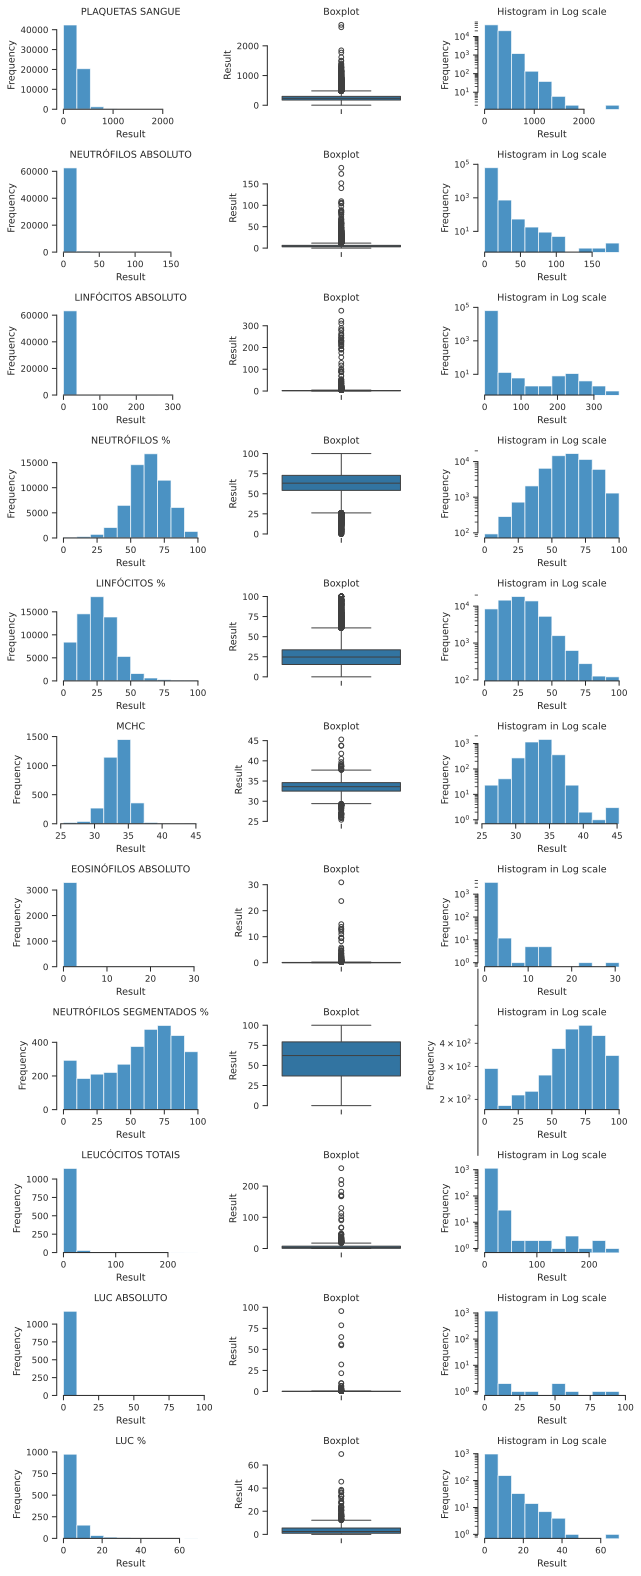

In [30]:
n = len(df_clean["Test"].unique())
fig, ax = plt.subplots(n, 3, figsize=(9, n*2))
for i,t in enumerate(df_clean["Test"].unique()):
    d = df_clean[df_clean["Test"] == t]["Result"]

    d.hist(bins=10, alpha=0.8, ax=ax[i,0])
    ax[i,0].set_xlabel('Result')
    ax[i,0].set_ylabel('Frequency')
    ax[i,0].set_title(t)
    ax[i,0].grid(False)

    sns.boxplot(y=d, ax=ax[i,1])
    ax[i,1].set_ylabel('Result')
    ax[i,1].set_title('Boxplot')

    d.hist(bins=10, alpha=0.8, log=True, ax=ax[i,2])
    ax[i,2].set_xlabel('Result')
    ax[i,2].set_ylabel('Frequency')
    ax[i,2].set_title(f'Histogram in Log scale')
    ax[i,2].grid(False)

plt.tight_layout()
sns.despine(trim=True)

plt.savefig('./fig/histograms.png')

Retiradas as amostras que não tem ID definido.

In [31]:
df_clean["ID"].value_counts().sort_values(ascending=False)

ID
99999999    5265
25361461     725
25843342     706
24725244     685
25883509     546
            ... 
18424856       1
21138584       1
22664967       1
18107983       1
24699381       1
Name: count, Length: 30911, dtype: int64

In [32]:
invalid_ID = df_clean["ID"].value_counts().sort_values(ascending=False).index[0]
df_clean = df_clean[df_clean['ID'] != invalid_ID]

print(f"Data points after clean-up: {len(df_clean):,}")

Data points after clean-up: 321,952


Avaliando IDs com mais de um teste realizado. Existe um grande número de IDs que tem ao menos 5 testes diferentes realizados. Foi encontrada a combinação de 5 testes com maior número de indivíduos. 

In [33]:
import itertools

In [34]:
n_ID = df_clean["ID"].value_counts().count()
print(f"Number of unique IDs: {n_ID:,}")

tests_by_ID = df_clean.groupby("ID")["Test"].nunique().value_counts().sort_index()
print(f"Number of unique tests per ID: \n{tests_by_ID}")

max_tests = tests_by_ID.idxmax()

Number of unique IDs: 30,910
Number of unique tests per ID: 
Test
1       284
3        46
4         1
5     30364
7        25
8       100
10       19
11       71
Name: count, dtype: int64


In [35]:
elements = df_clean["Test"].unique()
all_combinations = list(itertools.combinations(elements, max_tests))
print(f"Number of possible combinations of {max_tests} tests: {len(all_combinations):,}")

Number of possible combinations of 5 tests: 462


In [36]:
def ids_with_combination(df, test_list):
    filtered_df = df[df['Test'].isin(test_list)]
    id_test_counts = filtered_df.groupby('ID')['Test'].nunique()
    ids_with_all_tests = id_test_counts[id_test_counts == len(test_list)].index
    return ids_with_all_tests

n_ids = []
for combination in all_combinations:
    ids = ids_with_combination(df_clean, combination)
    n_ids.append(len(ids))

i_best = n_ids.index(max(n_ids))
best_combination = list(all_combinations[i_best])
print(f"Best combination of {max_tests} tests:\n{best_combination}")
print(f"Unique IDs: {max(n_ids):,}.")

Best combination of 5 tests:
['PLAQUETAS SANGUE', 'NEUTRÓFILOS ABSOLUTO', 'LINFÓCITOS ABSOLUTO', 'NEUTRÓFILOS %', 'LINFÓCITOS %']
Unique IDs: 30,535.


In [37]:
df_filtered = df_clean[df_clean['Test'].isin(best_combination)]
print(f"Data points after filter: {len(df_filtered):,}")

Data points after filter: 308,445


# Agrupamento dos Dados

Nova base de dados é construída agrupando os dados por ID. São utilizados apenas as amostras correspondentes aos 5 testes realizados pelo mesmo indivídio, no mesmo dia.

In [38]:
df_one_hot = pd.get_dummies(df_filtered, columns=['Test'], prefix='t')
rename_dict = {'t_'+c: c for c in best_combination}
df_one_hot = df_one_hot.rename(columns=rename_dict)
df_one_hot['n_tests'] = df_one_hot[best_combination].sum(axis=1)
for c in best_combination:
    df_one_hot[c] = df_one_hot[c] * df_one_hot['Result']
df_one_hot = df_one_hot.drop(columns=['Result'])

df_agg = df_one_hot.groupby(['Date','ID']).agg(
    {'Age':'mean',
     'Sex':'mean',
    'n_tests':'sum',
    **{c: 'sum' for c in best_combination}}
)

print(f"Initial number of aggregated samples: {len(df_agg):,}")

df_agg = df_agg[df_agg['n_tests'] == max_tests]
df_agg = df_agg.drop(columns=['n_tests'])

print(f"Samples with all {max_tests} tests: {len(df_agg):,}")

df_agg.head()

df_agg.to_csv('data_agg.csv')

Initial number of aggregated samples: 62,720
Samples with all 5 tests: 58,245
